In [1]:
import pandas as pd
import numpy as np
import torch
import gdown
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import warnings

# --- CONFIGURATION ---
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. DOWNLOAD DATA
file_ids = {
    'train_split.csv': '1IsyR3Xb_2cfvo457Fh8nE72VTifZb64W',
    'val_split.csv': '1wX4PeKO6fPeLmICA2xmJ3gDUqv_MjE4B',
    'test_split.csv': '1YSyXByVC105ifTZf-FX9IFjlAbZXbdSj',
    'feature_columns.txt': '1PJqBlBZuxocIyHWywBhtaynUn2Pw-y5_'
}
def download_from_drive(ids):
    for filename, fid in ids.items():
        if not os.path.exists(filename):
            url = f'https://drive.google.com/uc?id={fid}'
            gdown.download(url, filename, quiet=False)

download_from_drive(file_ids)

Downloading...
From (original): https://drive.google.com/uc?id=1IsyR3Xb_2cfvo457Fh8nE72VTifZb64W
From (redirected): https://drive.google.com/uc?id=1IsyR3Xb_2cfvo457Fh8nE72VTifZb64W&confirm=t&uuid=209fd577-9d7d-4b6c-98e8-0e0483987d84
To: /kaggle/working/train_split.csv
100%|██████████| 1.23G/1.23G [00:10<00:00, 119MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1wX4PeKO6fPeLmICA2xmJ3gDUqv_MjE4B
From (redirected): https://drive.google.com/uc?id=1wX4PeKO6fPeLmICA2xmJ3gDUqv_MjE4B&confirm=t&uuid=ccbb5562-a5af-4d7b-9486-6bad5c0e1314
To: /kaggle/working/val_split.csv
100%|██████████| 161M/161M [00:00<00:00, 195MB/s]  
Downloading...
From (original): https://drive.google.com/uc?id=1YSyXByVC105ifTZf-FX9IFjlAbZXbdSj
From (redirected): https://drive.google.com/uc?id=1YSyXByVC105ifTZf-FX9IFjlAbZXbdSj&confirm=t&uuid=f6b564ed-aad0-4a05-aa9a-1c5f86ef1083
To: /kaggle/working/test_split.csv
100%|██████████| 161M/161M [00:00<00:00, 181MB/s]  
Downloading...
From: https://drive.goog

In [3]:
# 2. DATA LOADING & 
device = "cuda"
test_df = pd.read_csv("test_split.csv")

y_test = torch.tensor(test_df['Sales'].values.astype(np.float32), device=device)
with open('feature_columns.txt', 'r') as f:
    features = [line.strip() for line in f.readlines()]
    
X_test_numeric = test_df[features].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

In [5]:
# SCRATCH GRADIENT BOOSTED REGRESSOR (CUDA)
class GBDTScratch:
    def __init__(self, n_estimators=10, max_depth=3, lr=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.lr = lr
        self.trees = []

    def fit(self, X, y):
        # Initial prediction (mean of target)
        self.base_pred = torch.mean(y)
        current_preds = torch.full_like(y, self.base_pred)

        for i in range(self.n_estimators):
            # Gradient Boosting: Predict the residuals (errors)
            residuals = y - current_preds
            
            # Build tree on residuals
            tree = self._build_tree(X, residuals, depth=0)
            self.trees.append(tree)
            
            # Update overall predictions with learning rate
            current_preds += self.lr * self._predict_tree(X, tree)
            
            # Requirement: Report RMSE at each boosting stage
           
            rmse = torch.sqrt(torch.mean((y - current_preds)**2))
            print(f"  > Boosting Round {i}, Residual RMSE: {rmse.item():.2f}")

    def _build_tree(self, X, res, depth):
        if depth >= self.max_depth or len(res) < 10:
            return torch.mean(res)

        n_features = X.shape[1]
        best_gain = -1
        split_idx, split_val = 0, 0

        # Optimization: Median-split on sampled features for speed
        for f_idx in range(n_features):
            feat_vals = X[:, f_idx]
            threshold = torch.median(feat_vals)
            
            left_mask = feat_vals <= threshold
            right_mask = ~left_mask
            
            if left_mask.sum() == 0 or right_mask.sum() == 0: continue
            
            # Variance Reduction Gain
            gain = torch.var(res) - (left_mask.sum()*torch.var(res[left_mask]) + 
                                     right_mask.sum()*torch.var(res[right_mask])) / len(res)
            
            if gain > best_gain:
                best_gain, split_idx, split_val = gain, f_idx, threshold

        left_mask = X[:, split_idx] <= split_val
        return {
            'split_idx': split_idx,
            'split_val': split_val,
            'left': self._build_tree(X[left_mask], res[left_mask], depth+1),
            'right': self._build_tree(X[~left_mask], res[~left_mask], depth+1)
        }

    def _predict_tree(self, X, tree):
        if not isinstance(tree, dict):
            return torch.full((X.shape[0],), tree, device=device)
        
        preds = torch.zeros(X.shape[0], device=device)
        left_mask = X[:, tree['split_idx']] <= tree['split_val']
        
        preds[left_mask] = self._predict_tree(X[left_mask], tree['left'])
        preds[~left_mask] = self._predict_tree(X[~left_mask], tree['right'])
        return preds

    def predict(self, X):
        y_pred = torch.full((X.shape[0],), self.base_pred, device=device)
        for tree in self.trees:
            y_pred += self.lr * self._predict_tree(X, tree)
        return torch.clamp(y_pred, min=0)

# 5. EVALUATION Metrics
def get_rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2)).item()
    
def get_mape(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error.
    Note: We add a small epsilon (1e-8) to the denominator to avoid 
    division by zero for days with 0 sales.
    """
    epsilon = 1e-8
    abs_error = torch.abs(y_true - y_pred)
    relative_error = abs_error / (torch.abs(y_true) + epsilon)
    mape = torch.mean(relative_error) * 100
    return mape.item()
    
def get_R2(y_true, y_pred):
    """
    Calculates the R-squared score.
    R2 = 1 - (Sum of Squared Residuals / Total Sum of Squares)
    """
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    # Avoid division by zero if all y_true values are identical
    if ss_tot == 0:
        return 0.0
        
    r2 = 1 - (ss_res / ss_tot)
    return r2.item()

In [6]:
url = f'https://drive.google.com/uc?id=180CgJhkaLgGi8AeKCkMKMotO86yZxnol'
gdown.download(url, "gbdt_model.pt", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=180CgJhkaLgGi8AeKCkMKMotO86yZxnol
From (redirected): https://drive.google.com/uc?id=180CgJhkaLgGi8AeKCkMKMotO86yZxnol&confirm=t&uuid=4e0566e6-d77a-45d6-ba5b-77f84eaad89a
To: /kaggle/working/gbdt_model.pt
100%|██████████| 27.7M/27.7M [00:00<00:00, 80.6MB/s]


'gbdt_model.pt'

In [7]:
gbdt_model = torch.load(
    "gbdt_model.pt",
    map_location=device,
    weights_only=False
)

## Calculate Predictions and Errors

This cell passes the test data through the loaded model, calculates the absolute difference between the prediction and actual sales, and attaches these results directly to the test dataframe so we can analyze the features alongside the mistakes.

In [8]:
# 1. Convert numpy array to PyTorch Tensor
X_test = torch.tensor(X_test_numeric, device=device)

# 2. Make predictions
with torch.no_grad():
    preds = gbdt_model.predict(X_test)

# 3. Move predictions back to CPU/NumPy for Pandas manipulation
preds_np = preds.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# 4. Attach to the DataFrame and calculate Absolute Error
test_df['Predictions'] = preds_np
test_df['Abs_Error'] = np.abs(test_df['Sales'] - test_df['Predictions'])

print("Predictions and errors successfully calculated!")

Predictions and errors successfully calculated!


In [27]:
y_test_tensor = torch.tensor(test_df['Sales'].values.astype(np.float32), device=device)
y_pred_tensor = torch.tensor(test_df['Predictions'].values.astype(np.float32), device=device)

#Create a mask for days where sales were greater than zero
mask = y_test_tensor > 0
# Calculate MAPE only for those days
mape_val = get_mape(y_test_tensor[mask], y_pred_tensor[mask])
r2_val = get_R2(y_test_tensor, y_pred_tensor)
rmse_val = get_rmse(y_test_tensor, y_pred_tensor)

print(f"Overall Test RMSE: {rmse_val:.2f}")
print(f"Overall Test MAPE: {mape_val:.2f}%")
print(f"Overall Test R2 Score: {r2_val:.4f}")

Overall Test RMSE: 492.76
Overall Test MAPE: 5.04%
Overall Test R2 Score: 0.9842


## Extract and Inspect the Worst Cases

First, we classify rows into "Reliable" (Low Error) and "Unreliable" (High Error) groups. This allows us to compare the feature distributions between the two.

In [11]:
# 1. Identify "Bad" vs "Good" predictions using a threshold (e.g., top 10% highest errors)
threshold = test_df['Abs_Error'].quantile(0.90)
test_df['Reliability'] = np.where(test_df['Abs_Error'] >= threshold, 'Low', 'High')

# 2. Extract the subset of "Bad" predictions
bad_preds_df = test_df[test_df['Reliability'] == 'Low'].copy()

print(f"Error Threshold: {threshold:.2f}")
print(f"Number of Low Reliability samples: {len(bad_preds_df)}")

Error Threshold: 701.05
Number of Low Reliability samples: 10370


## Feature Distribution Divergence

This cell automatically finds which features behave differently when the model fails. For example, if the average Promo value is 0.3 for good predictions but 0.8 for bad ones, the model likely struggles to handle promotions correctly.

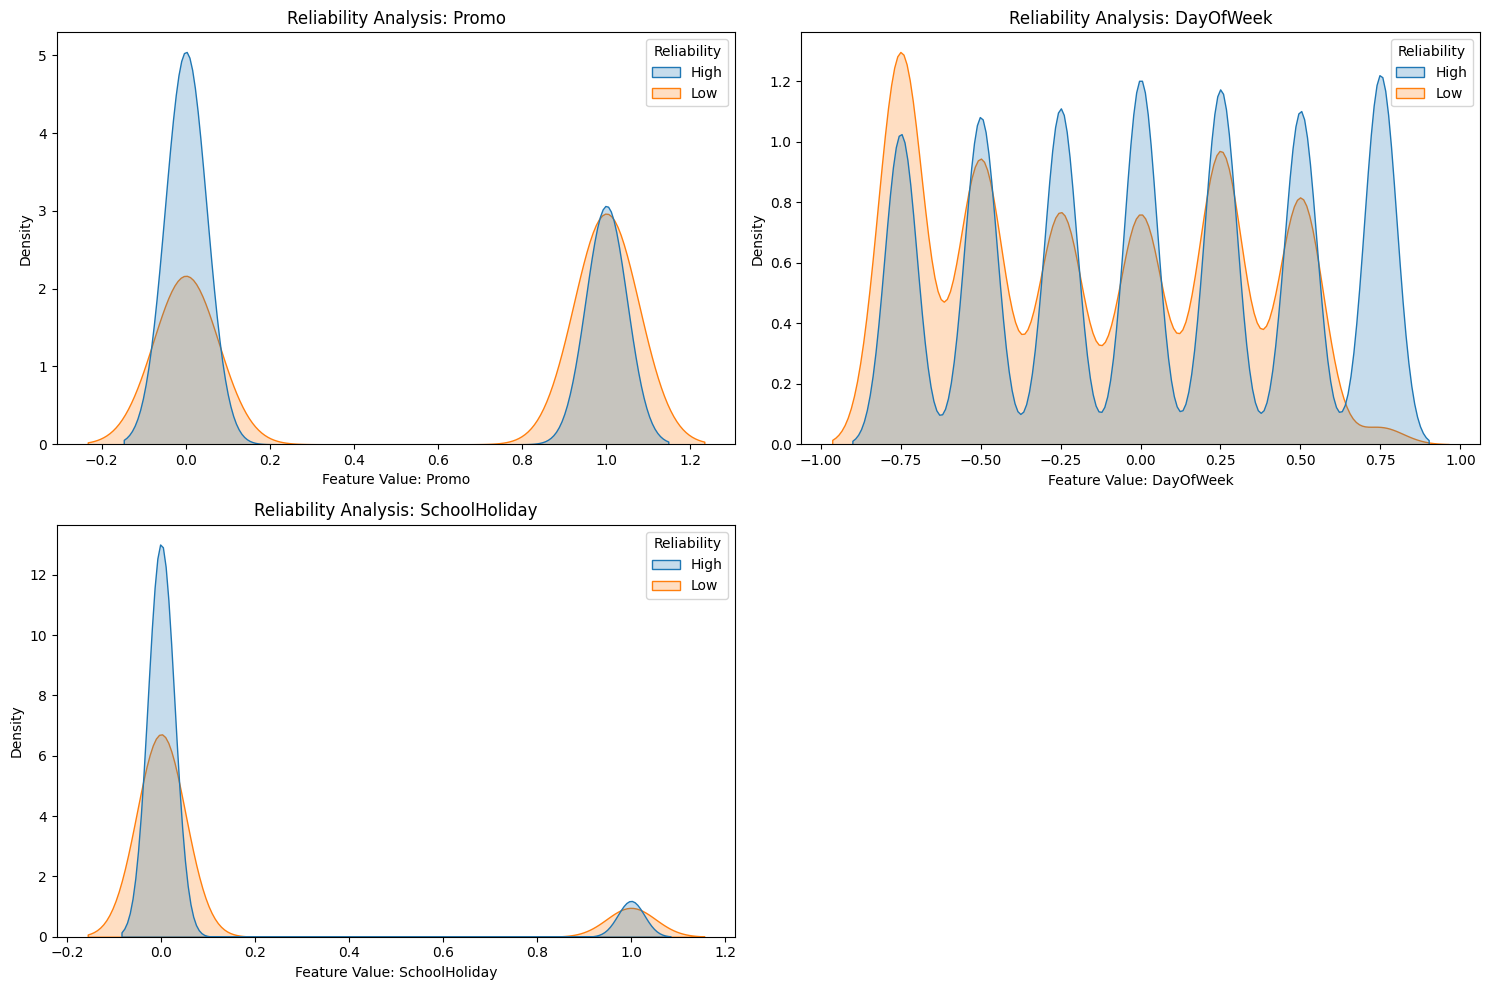

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# We pick a few key features to analyze for "unreliability patterns"
analysis_features = ['Promo', 'DayOfWeek', 'SchoolHoliday', 'StateHoliday'] 
analysis_features = [f for f in analysis_features if f in test_df.columns]

plt.figure(figsize=(15, 10))

for i, feature in enumerate(analysis_features):
    plt.subplot(2, 2, i+1)
    # Compare the distribution of the feature in Good vs Bad predictions
    sns.kdeplot(data=test_df, x=feature, hue='Reliability', common_norm=False, fill=True)
    plt.title(f'Reliability Analysis: {feature}')
    plt.xlabel(f'Feature Value: {feature}')

plt.tight_layout()
plt.show()

## Plot Analysis:

We observe that on monday (beginning of the week), the height of the graph corresponding to low reliability is meaningfully higher than that of the high reliability, which implies that our models has trouble with predicting sales that take place on mondays. the opposit is true for the weekend (sunday), where our model can predict sales with very high accuracy.

for the promo and school holiday graphs, we see that "High Reliability" (good prediction) curve is taller at both 0 and 1, it means that for the vast majority of days (both Promo and non-Promo), our GBDT model is doing exactly what it should. Most days follow a standard, predictable pattern that the model has learned well from the training data.

## Expanded Feature Distribution Divergence

This cell will show us if the model's failures are concentrated in specific "zones" of features like CompetitionDistance or during specific Holidays

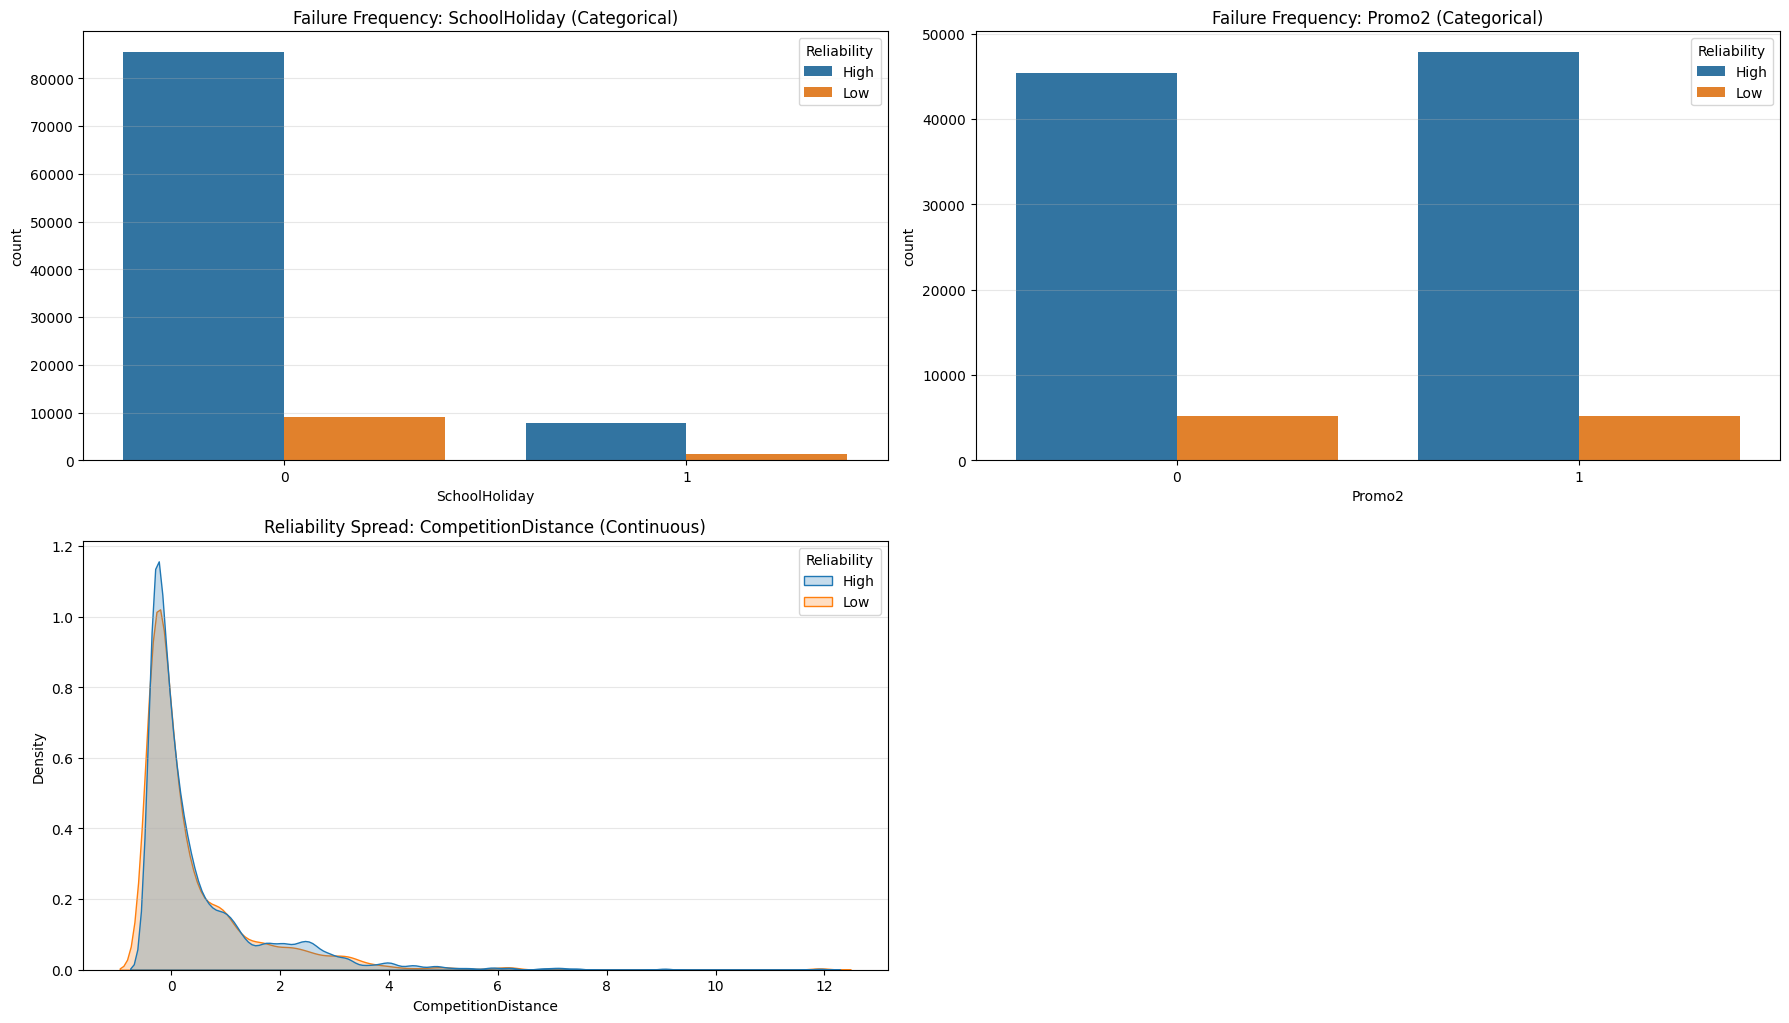

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features to analyze (Adjust these based on your exact column names)
new_analysis_features = ['StateHoliday', 'SchoolHoliday', 'Assortment', 'Promo2', 'CompetitionDistance']
# Ensure we only use features present in the dataframe
valid_features = [f for f in new_analysis_features if f in test_df.columns]

plt.figure(figsize=(18, 15))

for i, feature in enumerate(valid_features):
    plt.subplot(3, 2, i+1)
    
    # For continuous features like CompetitionDistance, we use KDE
    if test_df[feature].nunique() > 10:
        sns.kdeplot(data=test_df, x=feature, hue='Reliability', common_norm=False, fill=True)
        plt.title(f'Reliability Spread: {feature} (Continuous)')
    # For categorical/discrete features, we use a Count Plot to see frequency of errors
    else:
        sns.countplot(data=test_df, x=feature, hue='Reliability')
        plt.title(f'Failure Frequency: {feature} (Categorical)')
    
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Plot Analysis:

Our model seems to be robust to these features since the blue bars are much larger than the orange ones and the distribution of CompetitionDistance doesn't meaningfully differ between high and low reliability. Which means that whether or not the model prediction falls in the reliable category is independent of Competition distance.

## Multi-Instance Error Profiling

This step identifies "Error Hotspots." We group by specific feature values and calculate the Mean Absolute Error (MAE). This tells us, for instance, that the model is 50% less reliable on Mondays or during certain holiday types.


--- Error Profile by DayOfWeek ---


Abs_Error                           Sales Relative_Error_%
                 mean         std  count         mean                 
DayOfWeek                                                             
-0.75      401.907772  527.249455  14495  7820.424767         5.139206
-0.50      362.830881  406.130944  14495  7412.743636         4.894691
 0.25      341.441384  376.120274  15610  6683.289686         5.108882
 0.50      337.616809  365.166292  14495  6060.652984         5.570634
-0.25      330.193645  320.326923  14495  7133.991721         4.628456
 0.00      303.257236  348.708356  15610  6288.910314         4.822095
 0.75       46.498787  178.869587  14495   231.732321        20.065732


--- Error Profile by Promo ---


Abs_Error                           Sales Relative_Error_%
             mean         std  count         mean                 
Promo                                                             
1      383.818664  407.653234  41255  8096.130384         4.740767
0      250.930584  364.899348  62440  4546.929757         5.518682

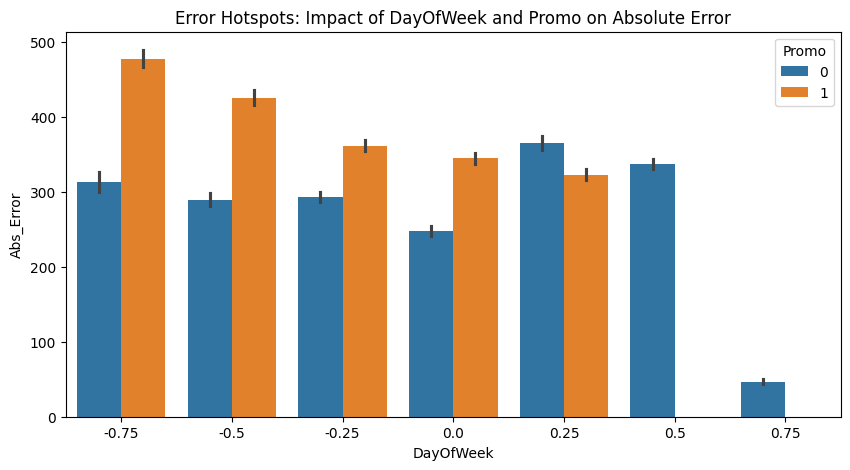

In [14]:
# Calculate error stats grouped by key categories
group_features = ['DayOfWeek', 'Promo', 'StoreType']
group_features = [f for f in group_features if f in test_df.columns]

for feature in group_features:
    profile = test_df.groupby(feature).agg({
        'Abs_Error': ['mean', 'std', 'count'],
        'Sales': 'mean'
    })
    # Calculate Relative Error (Error as % of Sales) for better context
    profile['Relative_Error_%'] = (profile['Abs_Error']['mean'] / profile['Sales']['mean']) * 100
    
    print(f"\n--- Error Profile by {feature} ---")
    display(profile.sort_values(('Abs_Error', 'mean'), ascending=False))

# Visualization of Relative Error %
plt.figure(figsize=(10, 5))
sns.barplot(x=test_df['DayOfWeek'], y=test_df['Abs_Error'], hue=test_df['Promo'])
plt.title("Error Hotspots: Impact of DayOfWeek and Promo on Absolute Error")
plt.show()

## Plot Analysis:

In contrast to distribution and density in the previous cell (how often we fail), here we have examined magnitude (how badly we fail). We observe that our model becomes less reliable when promo=1, as we see higher values of Abs_Error. We also see that our errors in promo = 1 situatons decrease as we move through the days of the week, while errors when promo = 0 remain relatively unchanged, with a substantial increase on friday and saturday and a sharp decline on sunday.

## Competition & Promo Interaction (Hotspot)

We want to see if the model fails more for stores that are close to competitors during a promotion (where price wars happen).

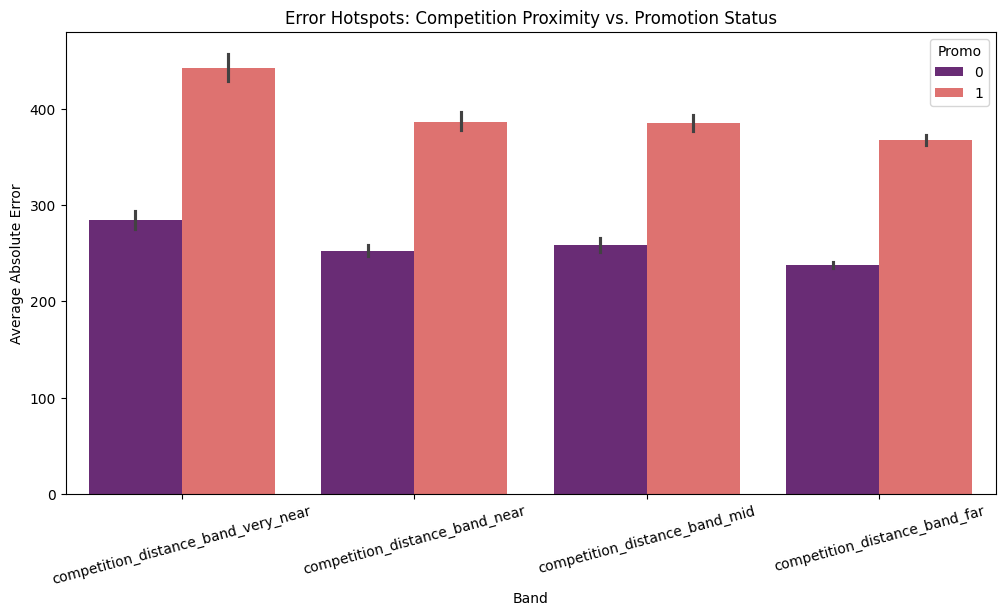

In [20]:
# Grouping by Competition Distance Bands
bands = ['competition_distance_band_very_near', 'competition_distance_band_near', 
         'competition_distance_band_mid', 'competition_distance_band_far']

# Melt these into a single column for plotting
hotspot_data = []
for band in bands:
    if band in test_df.columns:
        subset = test_df[test_df[band] == 1].copy()
        subset['Band'] = band
        hotspot_data.append(subset)

if hotspot_data:
    plot_df = pd.concat(hotspot_data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=plot_df, x='Band', y='Abs_Error', hue='Promo', palette='magma')
    plt.title('Error Hotspots: Competition Proximity vs. Promotion Status')
    plt.ylabel('Average Absolute Error')
    plt.xticks(rotation=15)
    plt.show()

## Plot Analysis:

We see that the graph has a greater height when the distance between competition is very near. This means that the model struggles in high-competition zones.

## Holiday Window Analysis

Sales usually spike right before a holiday. This plot will reveal if the model "under-predicts" during this critical window.

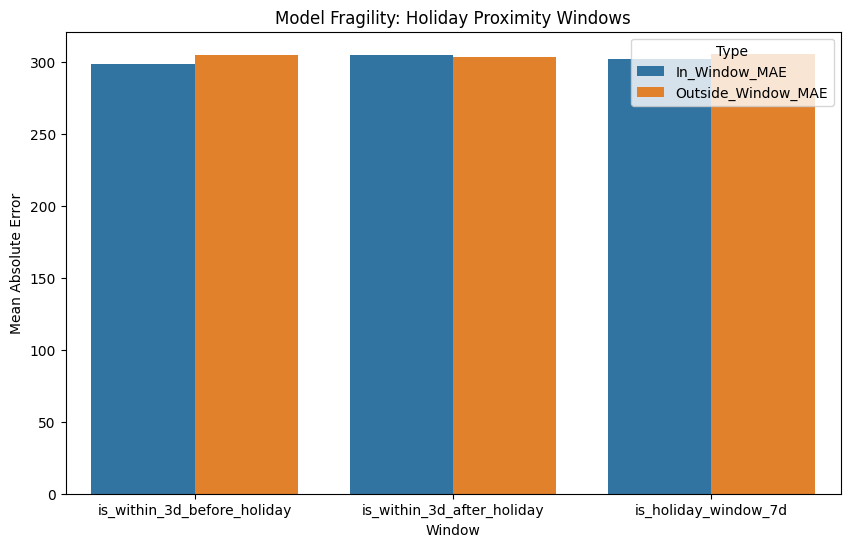

In [22]:
holiday_features = ['is_within_3d_before_holiday', 'is_within_3d_after_holiday', 'is_holiday_window_7d']
valid_hols = [f for f in holiday_features if f in test_df.columns]

if valid_hols:
    # Calculate Mean Error for each window
    hol_stats = []
    for f in valid_hols:
        mae_in = test_df[test_df[f] == 1]['Abs_Error'].mean()
        mae_out = test_df[test_df[f] == 0]['Abs_Error'].mean()
        hol_stats.append({'Window': f, 'In_Window_MAE': mae_in, 'Outside_Window_MAE': mae_out})
    
    hol_df = pd.DataFrame(hol_stats).melt(id_vars='Window', var_name='Type', value_name='MAE')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=hol_df, x='Window', y='MAE', hue='Type')
    plt.title('Model Fragility: Holiday Proximity Windows')
    plt.ylabel('Mean Absolute Error')
    plt.show()

## Plot analysis

We can see that being within holiday windows does not affect our model's accuracy, meaning that the model is robust to these features.